In [1]:
import random
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import PIL
from PIL import Image, ImageChops, ImageOps
import gc
import time
import math
from tqdm import tqdm
import argparse
import json
from random import shuffle

from albumentations import *
import imgaug
from imgaug import augmenters as iaa

In [ ]:
def to_float(img, max_value=None):
    if max_value is None:
        try:
            max_value = MAX_VALUES_BY_DTYPE[img.dtype]
        except KeyError:
            raise RuntimeError(
                "Can't infer the maximum value for dtype {}. You need to specify the maximum value manually by "
                "passing the max_value argument".format(img.dtype)
            )
    return img.astype("float32") / max_value


def from_float(img, dtype, max_value=None):
    if max_value is None:
        try:
            max_value = MAX_VALUES_BY_DTYPE[dtype]
        except KeyError:
            raise RuntimeError(
                "Can't infer the maximum value for dtype {}. You need to specify the maximum value manually by "
                "passing the max_value argument".format(dtype)
            )
    return (img * max_value).astype(dtype)


MAX_VALUES_BY_DTYPE = {
    np.dtype("uint8"): 255,
    np.dtype("uint16"): 65535,
    np.dtype("uint32"): 4294967295,
    np.dtype("float32"): 1.0,
}


In [ ]:
map_func = {}
map_func[0] = "Box Blur"
map_func[1] = "Gaussian Blur"
map_func[2] = "Median Blur"
map_func[3] = "JPEG Compression"
map_func[4] = "JPEG Double Compression"
map_func[5] = "JPEG Double Compression"
map_func[6] = "JPEG Double Compression"
map_func[7] = "JPEG Double Compression"
map_func[8] = "Nearest Resize"
map_func[9] = "Area Resize"
map_func[10] = "Cubic Resize"
map_func[11] = "Linear Resize"
map_func[12] = "Lanczos4 Resize"
map_func[13] = "WEBP Compression"
map_func[14] = "AutoContrast"
map_func[15] = "Impulse Noise"
map_func[16] = "Poisson Noise"
map_func[17] = "Gaussian Noise"
map_func[18] = "Erode Morph"
map_func[19] = "Dilate Morph"

In [ ]:
#FUNCTION BLOCK

def boxBlur(img):
  #DONE
  k = [29, 11, 13, 15, 17, 19, 25, 27, 21, 23, 3, 7, 5, 9, 33, 31]
  randint = random.randint(0, len(k) - 1)
  kernel = (k[randint], k[randint]) #Random kernel is chosen everytime
  image = cv2.blur(img, kernel)
  mp = {}
  mp['id'] = 0
  mp['name'] = "Box Blur"
  mp["parameter"] = "K = " + str(k[randint])
  return (image, mp)


def gaussianBlur(img):
  #DONE
  k = [33, 31, 5, 7, 3, 9, 11, 13, 15, 17, 19, 29, 21, 23, 25, 27]
  randint = random.randint(0, len(k) - 1)
  kernel = (k[randint], k[randint])
  image = cv2.GaussianBlur(img, kernel, 0)
  mp = {}
  mp['id'] = 1
  mp['name'] = "Gaussian Blur"
  mp["parameter"] = "K = " + str(k[randint])
  return (image, mp)


def medianBlur(img):
  #DONE
  k = [21, 23, 25, 27, 29, 19, 15, 17, 11, 13, 9, 3, 7, 5, 33, 31]
  randint = random.randint(0, len(k) - 1)
  kernel = k[randint]
  image = cv2.medianBlur(img, kernel) 
  mp = {}
  mp['id'] = 2
  mp['name'] = "Median Blur"
  mp["parameter"] = "K = " + str(k[randint])
  return (image, mp)


#def jpegCompression(img):
#  #Confused
#  k = [57, 53, 91, 95, 61, 65, 38, 100, 74, 70, 78, 48, 44, 40, 82, 87]
#  randint = random.randrange(0, len(k))
#  quality = k[randint]
#  encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
#  result, encimg = cv2.imencode('.jpg', img, encode_param)
#  decimg = cv2.imdecode(encimg, 1) #1 diye ki mean kore no idea
#  return decimg


def jpegCompression(image):
  #DONE
  k = [57, 53, 91, 95, 61, 65, 38, 100, 74, 70, 78, 48, 44, 40, 82, 87]
  randint = random.randrange(0, len(k))
  quality = k[randint]
  aug = JpegCompression(quality, quality) #2 params - lower and upper value
  augmented = aug(image=image)
  jpeg = augmented['image']
  #params = "3, Q = "
  #params += str(k[randint])
  mp = {}
  mp['id'] = 3
  mp['name'] = "JPEG Compression"
  mp["parameter"] = "Q = " + str(k[randint])
  return (jpeg, mp)


def jpegDoubleCompression1(image):
  k1 = [95, 36, 95, 61, 70, 95, 53, 87, 78, 87, 95, 70, 78, 78, 87, 53]
  k2 = [40, 74, 57, 65, 100, 65, 74, 100, 57, 48, 100, 65, 40, 48, 65, 40]
  randint = random.randrange(0, len(k1))
  quality1 = k1[randint]
  quality2 = k2[randint]
  result, encimg = cv2.imencode('.jpg', image, [int(cv2.IMWRITE_JPEG_QUALITY), quality1])
  decimg = cv2.imdecode(encimg, 1) 
  result1, encimg1 = cv2.imencode('.jpg', decimg, [int(cv2.IMWRITE_JPEG_QUALITY), quality2])
  decimg1 = cv2.imdecode(encimg1, 1)
  #params = "4, Q = "
  #params += str(k1[randint])
  #params += ", "
  #params += str(k2[randint])
  mp = {}
  mp['id'] = 4
  mp['name'] = "JPEG Double Compression"
  mp["parameter"] = "Q = " + str(k1[randint]) + ", " + str(k2[randint])
  return (decimg1, mp)

def jpegDoubleCompression2(image):
  k1 = [61, 87, 95, 70, 53, 61, 61, 44, 87, 95, 70, 87, 87, 53, 36, 44]
  k2 = [57, 57, 82, 91, 57, 40, 74, 48, 40, 91, 82, 82, 91, 65, 48, 74]
  randint = random.randrange(0, len(k1))
  quality1 = k1[randint]
  quality2 = k2[randint]
  #print(quality1)
  #print(quality2)
  result, encimg = cv2.imencode('.jpg', image, [int(cv2.IMWRITE_JPEG_QUALITY), quality1])
  decimg = cv2.imdecode(encimg, 1) 
  result1, encimg1 = cv2.imencode('.jpg', decimg, [int(cv2.IMWRITE_JPEG_QUALITY), quality2])
  decimg1 = cv2.imdecode(encimg1, 1)
  #params = "5, Q = "
  #params += str(k1[randint])
  #params += ", "
  #params += str(k2[randint])
  mp = {}
  mp['id'] = 5
  mp['name'] = "JPEG Double Compression"
  mp["parameter"] = "Q = " + str(k1[randint]) + ", " + str(k2[randint])
  return (decimg1, mp)

def jpegDoubleCompression3(image):
  k1 = [36, 61, 36, 53, 53, 36, 78, 78, 53, 70, 87, 61, 70, 95, 78, 44]
  k2 = [100, 91, 65, 48, 62, 57, 100, 74, 91, 57, 74, 48, 40, 48, 91, 40]
  randint = random.randrange(0, len(k1))
  quality1 = k1[randint]
  quality2 = k2[randint]
  #print(quality1)
  #print(quality2)
  result, encimg = cv2.imencode('.jpg', image, [int(cv2.IMWRITE_JPEG_QUALITY), quality1])
  decimg = cv2.imdecode(encimg, 1) 
  result1, encimg1 = cv2.imencode('.jpg', decimg, [int(cv2.IMWRITE_JPEG_QUALITY), quality2])
  decimg1 = cv2.imdecode(encimg1, 1)
  #params = "6, Q = "
  #params += str(k1[randint])
  #params += ", "
  #params += str(k2[randint])
  mp = {}
  mp['id'] = 6
  mp['name'] = "JPEG Double Compression"
  mp["parameter"] = "Q = " + str(k1[randint]) + ", " + str(k2[randint])
  return (decimg1, mp)

def jpegDoubleCompression4(image):
  k1 = [78, 36, 53, 44, 36, 36, 70, 61, 61, 44, 78, 44, 44, 95, 70, 44]
  k2 = [65, 40, 100, 100, 91, 82, 74, 100, 62, 62, 62, 57, 65, 74, 46, 91]
  randint = random.randrange(0, len(k1))
  quality1 = k1[randint]
  quality2 = k2[randint]
  #print(quality1)
  #print(quality2)
  result, encimg = cv2.imencode('.jpg', image, [int(cv2.IMWRITE_JPEG_QUALITY), quality1])
  decimg = cv2.imdecode(encimg, 1) 
  result1, encimg1 = cv2.imencode('.jpg', decimg, [int(cv2.IMWRITE_JPEG_QUALITY), quality2])
  decimg1 = cv2.imdecode(encimg1, 1)
  #params = "7, Q = "
  #params += str(k1[randint])
  #params += ", "
  #params += str(k2[randint])
  mp = {}
  mp['id'] = 7
  mp['name'] = "JPEG Double Compression"
  mp["parameter"] = "Q = " + str(k1[randint]) + ", " + str(k2[randint])
  return (decimg1, mp)

#def horizontalFlip(image):
#    aug = HorizontalFlip(p=1)
#   augmented = aug(image=image)
#   flipped_image = augmented['image']
#    return flipped_image

#def verticalFlip(image):
#    aug = VerticalFlip(p=1)
#    augmented = aug(image=image)
#    flipped_image = augmented['image']
#    return flipped_image

#def transpose(image):
#    aug = Transpose(p=1)
#    augmented = aug(image=image)
#    image_transpose = augmented['image']
#    return image_transpose

#def flip(image):
#    aug = Flip()
#    augmented = aug(image=image)
#    image_od = augmented['image']
#    return image_od

#def gaussNoise(image):
#    aug = GaussNoise(var_limit=(10.0, 50.0), always_apply=True, p=1)
#    augmented = aug(image=image)
#    image_od = augmented['image']
#    return image_od

#def additiveGaussianNoise(image):
#    aug = IAAAdditiveGaussianNoise(p = 1)
#    augmented = aug(image=image)
#    image_od = augmented['image']
#    return image_od


def nearestResize(image):
    #DONE
    h, w = image.shape[:2]
    k = [0.95, 0.20, 0.25, 0.31, 0.79, 0.73, 0.36, 0.41, 0.47, 0.52, 0.57, 0.84, 0.89, 0.15, 0.63, 0.68]
    randint = random.randrange(0, len(k))
    scale = k[randint]
    interpolation = cv2.INTER_NEAREST
    downscaled = cv2.resize(image, None, fx=scale, fy=scale, interpolation=interpolation)
    upscaled = cv2.resize(downscaled, (h, w), interpolation=interpolation)
    #params = "8, S = "
    #params += str(k[randint])
    mp = {}
    mp['id'] = 8
    mp['name'] = "Nearest Resize"
    mp["parameter"] = "S = " + str(k[randint]) 
    return (upscaled, mp)

def areaResize(image):
    #DONE
    h, w = image.shape[:2]
    k = [0.95, 0.73, 0.79, 0.36, 0.31, 0.89, 0.84, 0.63, 0.68, 0.25, 0.20, 0.57, 0.52, 0.15, 0.41, 0.47]
    randint = random.randrange(0, len(k))
    interpolation = cv2.INTER_AREA
    scale = k[randint]
    image = to_float(image)
    downscaled = cv2.resize(image, None, fx=scale, fy=scale, interpolation=interpolation)
    upscaled = cv2.resize(downscaled, (h, w), interpolation=interpolation)
    upscaled = from_float(np.clip(upscaled, 0, 1), dtype=np.dtype("uint8"))
    #params = "9, S = "
    #params += str(k[randint])
    mp = {}
    mp['id'] = 9
    mp['name'] = "Area Resize"
    mp["parameter"] = "S = " + str(k[randint]) 
    return (upscaled, mp)

def cubicResize(image):
    #DONE
    h, w = image.shape[:2]
    k = [0.36, 0.68, 0.63, 0.84, 0.89, 0.31, 0.79, 0.73, 0.95, 0.47, 0.41, 0.15, 0.57, 0.52, 0.25, 0.20]
    randint = random.randrange(0, len(k))
    interpolation = cv2.INTER_CUBIC
    scale = k[randint]
    image = to_float(image)
    downscaled = cv2.resize(image, None, fx=scale, fy=scale, interpolation=interpolation)
    upscaled = cv2.resize(downscaled, (h, w), interpolation=interpolation)
    upscaled = from_float(np.clip(upscaled, 0, 1), dtype=np.dtype("uint8"))
    #params = "10, S = "
    #params += str(k[randint])
    mp = {}
    mp['id'] = 10
    mp['name'] = "Cubic Resize"
    mp["parameter"] = "S = " + str(k[randint]) 
    return (upscaled, mp)

def linearResize(image):
    #DONE
    h, w = image.shape[:2]
    k = [0.41, 0.47, 0.95, 0.73, 0.79, 0.36,0.31, 0.84, 0.63, 0.68, 0.25, 0.20, 0.57, 0.52, 0.89, 0.15]
    randint = random.randrange(0, len(k))
    interpolation = cv2.INTER_LINEAR
    scale = k[randint]
    image = to_float(image)
    downscaled = cv2.resize(image, None, fx=scale, fy=scale, interpolation=interpolation)
    upscaled = cv2.resize(downscaled, (h, w), interpolation=interpolation)
    upscaled = from_float(np.clip(upscaled, 0, 1), dtype=np.dtype("uint8"))
    #params = "11, S = "
    #params += str(k[randint])
    mp = {}
    mp['id'] = 11
    mp['name'] = "Linear Resize"
    mp["parameter"] = "S = " + str(k[randint]) 
    return (upscaled, mp)

def lanczos4Resize(image):
    #DONE
    h, w = image.shape[:2]
    k = [0.36, 0.31, 0.79, 0.73, 0.47, 0.41, 0.89, 0.84, 0.15, 0.52, 0.57, 0.25, 0.20, 0.68, 0.63, 0.95]
    randint = random.randrange(0, len(k))
    interpolation = cv2.INTER_LANCZOS4
    scale = k[randint]
    image = to_float(image)
    downscaled = cv2.resize(image, None, fx=scale, fy=scale, interpolation=interpolation)
    upscaled = cv2.resize(downscaled, (h, w), interpolation=interpolation)
    upscaled = from_float(np.clip(upscaled, 0, 1), dtype=np.dtype("uint8"))
    #params = "12, S = "
    #params += str(k[randint])
    mp = {}
    mp['id'] = 12
    mp['name'] = "Lanczos4 Resize"
    mp["parameter"] = "S = " + str(k[randint]) 
    return (upscaled, mp)


def webpComp(image):
    #DONE
    quality_flag = cv2.IMWRITE_WEBP_QUALITY
    k = [53, 87, 82, 100, 65, 61, 95, 91, 36, 57, 78, 70, 74, 40, 44, 48]
    randint = random.randrange(0, len(k))
    quality = k[randint]
    tp = ".webp"
    _, encoded_img = cv2.imencode(tp, image, (int(quality_flag), quality))
    img = cv2.imdecode(encoded_img, cv2.IMREAD_UNCHANGED)
    mp = {}
    mp['id'] = 13
    mp['name'] = "WEPB Compression"
    mp["parameter"] = "Q = " + str(k[randint]) 
    return (img, mp)


#def autoContrast(image):
#    k = [2, 3, 0, 1, 6, 7, 4, 5]
#    randint = random.randrange(0, len(k))
#    cutoff = k[randint]
#    aug = iaa.pillike.Autocontrast(cutoff)
#    augmented = aug(image=image)
#    return augmented

def autoContrast(image):
    ignore = None
    k = [2, 3, 0, 1, 6, 7, 4, 5]
    randint = random.randrange(0, len(k))
    cutoff = k[randint]
    #params = "14, C = "
    #params += str(cutoff)
    mp = {}
    mp['id'] = 14
    mp['name'] = "AutoContrast"
    mp["parameter"] = "C = " + str(cutoff) 

    return (np.array(
      PIL.ImageOps.autocontrast(
        PIL.Image.fromarray(image),
        cutoff=cutoff, ignore=ignore
      )
    ), mp)

def histEq(image):
    k = [7,6,5,4,3,2,1]
    randint = random.randrange(0, len(k))
    seed = k[randint]
    aug = iaa.HistogramEqualization(seed)
    augmented = aug(image = image)
    return augmented

def impulseNoise(image):
    k = [13, 11, 17, 15, 9, 3, 5, 7, 28, 26, 24, 22, 20, 30, 32, 35]
    randint = random.randrange(0, len(k))
    prob = k[randint]
    prob /= 100.0
    #params = "15, P = "
    #params += str(k[randint])
    mp = {}
    mp['id'] = 15
    mp['name'] = "Impulse Noise"
    mp["parameter"] = "P = " + str(k[randint]) 
    #print(prob)
    aug = iaa.SaltAndPepper(prob)
    augmented = aug(image = image)
    return (augmented, mp)

def poissonNoise(image):
    k = [24, 26, 20, 22, 28, 3, 7, 5, 9, 35, 32, 30, 15, 17, 11, 13]
    randint = random.randint(0, len(k))
    lam = 1.0 * k[randint]
    #params = "16, L = "
    #params += str(k[randint])
    mp = {}
    mp['id'] = 16
    mp['name'] = "Poisson Noise"
    mp["parameter"] = "L = " + str(k[randint]) 
    aug = iaa.AdditivePoissonNoise(lam=lam)
    augmented = aug(image = image)
    return (augmented, mp)

def gaussianNoise(image):
    k = [3, 7, 5, 9, 30, 32, 35, 22, 20, 26, 24, 28, 17, 15, 13, 11]
    randint = random.randrange(0, len(k))
    scale = k[randint]
    aug = iaa.AdditiveGaussianNoise(scale=scale)
    augmented = aug(image = image)
    #params = "17, S = "
    #params += str(k[randint])
    mp = {}
    mp['id'] = 17
    mp['name'] = "Gaussian Noise"
    mp["parameter"] = "S = " + str(k[randint]) 
    return (augmented, mp)

def erodeMorph(image):
    k = [16, 31, 34, 21, 23, 25, 27, 29, 8, 2, 6, 4, 19, 14, 10, 12]
    randint = random.randrange(0, len(k))
    kernel = np.ones((k[randint], k[randint]), np.uint8)
    erosion = cv2.erode(image, kernel,iterations = 1)
    #params = "18, S = "
    #params += str(k[randint])
    mp = {}
    mp['id'] = 18
    mp['name'] = "Erode Morph"
    mp["parameter"] = "S = " + str(k[randint]) 
    return (erosion, mp)

def dilateMorph(image):
    k = [21, 23, 25, 27, 19, 14, 16, 10, 12, 29, 31, 34, 8, 2, 4, 6]
    randint = random.randrange(0, len(k))
    kernel = np.ones((k[randint], k[randint]), np.uint8)
    dilation = cv2.dilate(image, kernel,iterations = 1)
    #params = "19, S = "
    #params += str(k[randint])
    mp = {}
    mp['id'] = 19
    mp['name'] = "Dilate Morph"
    mp["parameter"] = "S = " + str(k[randint]) 
    return (dilation, mp)

def openMorph(image):
    #Changes dimension
    k = [10, 12, 14, 16, 19, 21, 23, 25, 27, 2, 6, 4, 8, 31, 34, 29]
    randint = random.randrange(0, len(k))
    print(image.shape)
    kernel = np.ones((k[randint], k[randint]), np.uint8)
    print(k[randint])
    print(kernel.shape)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    print(opening.shape)
    return opening

def closeMorph(image):
    #Changes shape
    k = [19, 16, 14, 12, 10, 27, 23, 21, 25, 29, 34, 31, 6, 4, 2, 8]
    randint = random.randrange(0, len(k))
    #print(image.shape)
    kernel = np.ones((k[randint], k[randint]), np.uint8)
    #print(k[randint])
    #print(kernel.shape)
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    print(closing.shape)
    return closing

#def quantize(image):
#    k = [50, 125, 225, 175, 100, 200, 150, 75]
#    randint = random.randrange(0, len(k))
#    colors = k[randint]
#    print(colors)
#    im_pil = Image.fromarray(img)
#    op = im_pil.quantize(colors = colors)
#    result = np.asarray(op)
#   return result


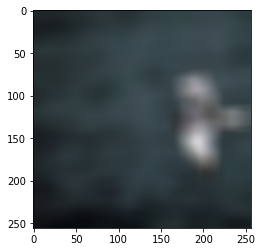

{'id': 0, 'name': 'Box Blur', 'parameters': 'K = 25'}


In [ ]:
#TEST every function ~~~~ 
ans = boxBlur(Img)

plt.imshow(ans[0])
plt.show()
print(ans[1])

function:**In pass an image -> get augmented images**

In [ ]:
def augment(image):
  seed = random.randrange(0, 20) # 0 - 19 -> 20 augs
  #print(seed)
  if seed == 0:
    return boxBlur(image)
  elif seed == 1:
    return gaussianBlur(image)
  elif seed == 2:
    return medianBlur(image)
  elif seed == 3:
    return jpegCompression(image)
  elif seed == 4:
    return jpegDoubleCompression1(image)
  elif seed == 5:
    return jpegDoubleCompression2(image)
  elif seed == 6:
    return jpegDoubleCompression3(image)
  elif seed == 7:
    return jpegDoubleCompression4(image)
  elif seed == 8:
    return nearestResize(image)
  elif seed == 9:
    return areaResize(image)
  elif seed == 10:
    return cubicResize(image)
  elif seed == 11:
    return linearResize(image)
  elif seed == 12:
    return lanczos4Resize(image)
  elif seed == 13:
    return webpComp(image)
  elif seed == 14:
    return autoContrast(image)
  #images.append(histEq(image))
  elif seed == 15:
    return impulseNoise(image)
  elif seed == 16:
    return poissonNoise(image)
  elif seed == 17:
    return gaussianNoise(image)
  elif seed == 18:
    return erodeMorph(image)
  elif seed == 19:
    return dilateMorph(image)

In [ ]:
def solve(path):
  img = cv2.imread(path) #reading from path
  #print(path)
  image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  #plt.imshow(image)
  #plt.show()
  patch_list = []
  for i in range(0, image.shape[0], 256):
    for j in range(0, image.shape[1], 256):
      x = i + 256
      y = j + 256
      if x > image.shape[0] or y > image.shape[1]:
        break
      patch = image[i : x, j : y]
      augs = augment(patch)
      #plt.imshow(augs[0])
      #plt.show()
      #print(augs[1])
      patch_list.append(augment(patch)) #augmented -> return type: (image, string) tuple
  return patch_list
 # return random_aug

1


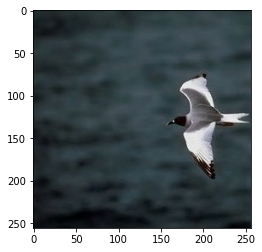

{'id': 5, 'name': 'JPEG Double Compression', 'parameter': 'Q = 87, 91'}


In [ ]:
ret = solve(path)
#plt.imshow(image)
#plt.show()
print(len(ret))
ans = ret[0] #0th index-> tuple (image, dict)
plt.imshow(ans[0])
plt.show()
print(ans[1])

In [ ]:
def ELA(param, DIR_ROOT):
    """Performs Error Level Analysis over a directory of images"""
    
    img_path = param['img_path']
    ela_path = param['ela_path']
    root_dir = param['root_dir']

    ROOT = os.path.join(DIR_ROOT, root_dir)
    
    TEMP = os.path.join(ROOT, img_path[:-4]+'ela_' + 'temp.jpg')
    SCALE = 25
    original = Image.open(os.path.join(ROOT, img_path))
    try:
        original.save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original, temporary)
        
    except:
        original.convert('RGB').save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original.convert('RGB'), temporary)
        
       
    d = diff.load()
    
    WIDTH, HEIGHT = diff.size
    for x in range(WIDTH):
        for y in range(HEIGHT):
            d[x, y] = tuple(k * SCALE for k in d[x, y])
    
    diff.save(os.path.join(ROOT,ela_path))
    os.remove(TEMP)

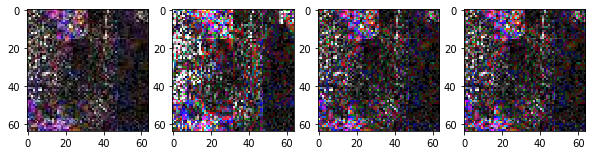

In [12]:
from albumentations.augmentations.functional import image_compression
from PIL import Image, ImageChops

img = cv2.imread('H:/image_manipulation/Image_Manipulation_Dataset/COVERAGE/image_patch_64/1t/9.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ela_orig = cv2.imread('H:/image_manipulation/Image_Manipulation_Dataset/COVERAGE/image_patch_64/1t/9_ela.jpg')
ela_orig = cv2.cvtColor(ela_orig, cv2.COLOR_BGR2RGB)


pil_ori_image = Image.fromarray(img)
output = BytesIO()
pil_ori_image.save(output, format="JPEG", quality=80)
pil_compressed_image = Image.open(output)
diff = ImageChops.difference(pil_ori_image, pil_compressed_image)
d = diff.load()
WIDTH, HEIGHT = diff.size
SCALE = 25
for x in range(WIDTH):
    for y in range(HEIGHT):
        d[x, y] = tuple(k * SCALE for k in d[x, y])
ela_new = np.array(diff)


pil_only_img = Image.open('H:/image_manipulation/Image_Manipulation_Dataset/COVERAGE/image_patch_64/1t/9.png')
pil_only_img.save('temp.jpg', quality=90)
temporary = Image.open('temp.jpg')
diff2 = ImageChops.difference(pil_only_img, temporary)
d2 = diff2.load()
WIDTH, HEIGHT = diff2.size
for x in range(WIDTH):
    for y in range(HEIGHT):
        d2[x, y] = tuple(k * SCALE for k in d2[x, y])
os.remove('temp.jpg')

pil_image = Image.open('H:/image_manipulation/Image_Manipulation_Dataset/COVERAGE/image_patch_64/1t/9.png')
output = BytesIO()
pil_image.save(output, format="JPEG", quality=90)
compressed_pil = Image.open(output)
diff3 = ImageChops.difference(pil_image, compressed_pil)
d3 = diff3.load()
WIDTH, HEIGHT = diff3.size
SCALE = 25
for x in range(WIDTH):
    for y in range(HEIGHT):
        d3[x, y] = tuple(k * SCALE for k in d3[x, y])
diff3 = np.array(diff3)

plt.figure(figsize=(10,20))
plt.subplot(1,4,1)
plt.imshow(ela_orig)
plt.subplot(1,4,2)
plt.imshow(ela_new)
plt.subplot(1,4,3)
plt.imshow(diff2)
plt.subplot(1,4,4)
plt.imshow(diff3)
plt.show()

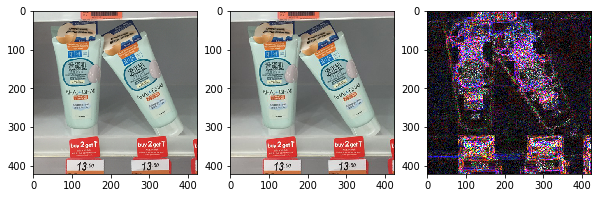

<class 'numpy.ndarray'>


In [8]:
from io import BytesIO

pil_image = Image.open('G:/IMANIP Datasets/COVERAGE/image/1t.tif')
output = BytesIO()
pil_image.save(output, format="JPEG", quality=90)
compressed = Image.open(output)

diff = ImageChops.difference(pil_image, compressed)
d = diff.load()
WIDTH, HEIGHT = diff.size
SCALE = 25
for x in range(WIDTH):
    for y in range(HEIGHT):
        d[x, y] = tuple(k * SCALE for k in d[x, y])
diff = np.array(diff)

plt.figure(figsize=(10,20))
plt.subplot(1,3,1)
plt.imshow(pil_image)
plt.subplot(1,3,2)
plt.imshow(compressed)
plt.subplot(1,3,3)
plt.imshow(diff)
plt.show()

print(type(diff))